<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline


### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [3]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-01-30 10:39:14--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2019-01-30 10:39:14 (13.3 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [4]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df.shape

(346, 10)

### Convert to date time object 

In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [8]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following packages will be UPDATED:

    seaborn: 0.8.0-py35h15a2772_0 --> 0.9.0-py35_0 anaconda

seaborn-0.9.0- 100% |################################| Time: 0:00:00   6.79 MB/s


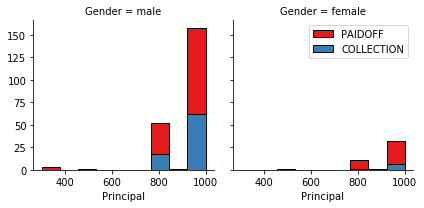

In [9]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

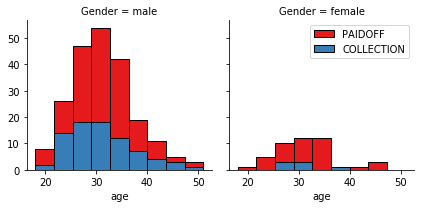

In [13]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

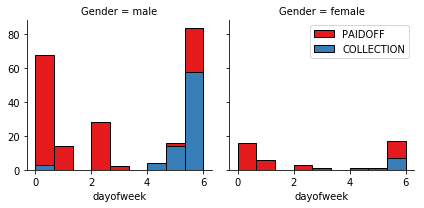

In [14]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [15]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [16]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [17]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [18]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [19]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [20]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [21]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [22]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [23]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [156]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

In [157]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-01-30 11:57:45--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2019-01-30 11:57:45 (14.3 MB/s) - ‘loan_train.csv’ saved [23101/23101]



In [158]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [159]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 0.58,  0.52,  0.92,  2.6 , -0.42,  2.33, -0.65,  0.42],
       [ 0.58,  0.52,  0.92,  2.6 , -0.42,  0.34, -1.52, -2.38],
       [ 0.58,  0.52, -0.96,  2.6 ,  0.72, -0.65,  1.1 ,  0.42],
       [ 0.58,  0.52,  0.92,  3.39, -0.31, -0.49,  1.1 , -2.38],
       [ 0.58,  0.52,  0.92,  3.39, -0.31, -0.32,  1.1 ,  0.42]])

In [160]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [161]:
from sklearn.neighbors import KNeighborsClassifier

In [162]:
k = 6
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform')

In [163]:
yhat = neigh.predict(X_test)
yhat[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [164]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.996376811594
Test set Accuracy:  1.0


In [165]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

1.0

In [166]:
print (classification_report(y_test, yhat))

             precision    recall  f1-score   support

 COLLECTION       1.00      1.00      1.00        15
    PAIDOFF       1.00      1.00      1.00        55

avg / total       1.00      1.00      1.00        70



# Decision Tree

In [139]:
import numpy as np 
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

In [140]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-01-30 11:55:38--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2019-01-30 11:55:38 (14.7 MB/s) - ‘loan_train.csv’ saved [23101/23101]



In [141]:
my_data = pd.read_csv("loan_train.csv", delimiter=",")
my_data[0:5]

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [142]:
X = my_data[['loan_status', 'Principal', 'terms', 'effective_date', 'due_date', 'age', 'education', 'Gender']].values
X[0:7]

array([['PAIDOFF', 1000, 30, '9/8/2016', '10/7/2016', 45,
        'High School or Below', 'male'],
       ['PAIDOFF', 1000, 30, '9/8/2016', '10/7/2016', 33, 'Bechalor',
        'female'],
       ['PAIDOFF', 1000, 15, '9/8/2016', '9/22/2016', 27, 'college', 'male'],
       ['PAIDOFF', 1000, 30, '9/9/2016', '10/8/2016', 28, 'college',
        'female'],
       ['PAIDOFF', 1000, 30, '9/9/2016', '10/8/2016', 29, 'college', 'male'],
       ['PAIDOFF', 1000, 30, '9/9/2016', '10/8/2016', 36, 'college', 'male'],
       ['PAIDOFF', 1000, 30, '9/9/2016', '10/8/2016', 28, 'college', 'male']], dtype=object)

In [143]:
from sklearn import preprocessing
le_loan_date = preprocessing.LabelEncoder()
le_loan_date.fit(['COLLECTION', 'PAIDOFF'])
X[:,0] = le_loan_date.transform(X[:,0]) 

le_eff_date = preprocessing.LabelEncoder()
le_eff_date.fit(['9/8/2016', '9/9/2016', '9/10/2016', '9/11/2016', '9/12/2016', '9/13/2016', '9/14/2016'])
X[:,3] = le_eff_date.transform(X[:,3]) 

le_due_date = preprocessing.LabelEncoder()
le_due_date.fit(['9/16/2016', '9/17/2016', '9/18/2016', '9/19/2016', '9/22/2016', '9/23/2016', '9/24/2016', '9/25/2016', '9/26/2016', '9/27/2016', '9/28/2016',
                 '10/7/2016', '10/8/2016', '10/9/2016', '10/10/2016', '10/11/2016', '10/12/2016', '10/13/2016', '10/25/2016', '10/26/2016', '11/9/2016', '11/10/2016', 
                 '11/12/2016'])
X[:,4] = le_due_date.transform(X[:,4]) 


le_education = preprocessing.LabelEncoder()
le_education.fit(['Bechalor', 'High School or Below', 'college', 'Master or Above'])
X[:,6] = le_education.transform(X[:,6]) 

le_Gender = preprocessing.LabelEncoder()
le_Gender.fit(['female', 'male'])
X[:,7] = le_Gender.transform(X[:,7])


X[0:7]


array([[1, 1000, 30, 5, 6, 45, 1, 1],
       [1, 1000, 30, 5, 6, 33, 0, 0],
       [1, 1000, 15, 5, 16, 27, 3, 1],
       [1, 1000, 30, 6, 7, 28, 3, 0],
       [1, 1000, 30, 6, 7, 29, 3, 1],
       [1, 1000, 30, 6, 7, 36, 3, 1],
       [1, 1000, 30, 6, 7, 28, 3, 1]], dtype=object)

In [144]:
y = my_data["loan_status"]
y[0:7]

0    PAIDOFF
1    PAIDOFF
2    PAIDOFF
3    PAIDOFF
4    PAIDOFF
5    PAIDOFF
6    PAIDOFF
Name: loan_status, dtype: object

In [145]:
from sklearn.model_selection import train_test_split

In [146]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

In [147]:
X_trainset.shape
y_trainset.shape


(242,)

In [148]:
X_testset.shape
y_testset.shape


(104,)

In [149]:
LoanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
LoanTree

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [150]:
LoanTree.fit(X_trainset,y_trainset)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [151]:
predTree = LoanTree.predict(X_testset)

In [152]:
print (predTree [0:5])
print (y_testset [0:5])

['PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'PAIDOFF']
73        PAIDOFF
24        PAIDOFF
282    COLLECTION
295    COLLECTION
163       PAIDOFF
Name: loan_status, dtype: object


In [153]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

DecisionTrees's Accuracy:  1.0


In [154]:
print (classification_report(y_test, yhat))

             precision    recall  f1-score   support

          1       0.79      1.00      0.88        55
          2       0.00      0.00      0.00        15

avg / total       0.62      0.79      0.69        70



/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [155]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

0.7857142857142857

NameError: name 'tree' is not defined

# Support Vector Machine

In [50]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

In [51]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-01-30 10:47:39--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2019-01-30 10:47:39 (11.3 MB/s) - ‘loan_train.csv’ saved [23101/23101]



In [53]:
loan_df = pd.read_csv("loan_train.csv")
loan_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


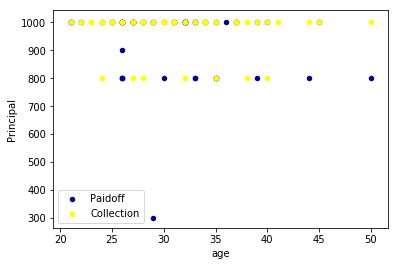

In [58]:
ax = loan_df[loan_df['loan_status'] == 'PAIDOFF'][0:50].plot(kind='scatter', x='age', y='Principal', color='DarkBlue', label='Paidoff');
loan_df[loan_df['loan_status'] == 'COLLECTION'][0:50].plot(kind='scatter', x='age', y='Principal', color='Yellow', label='Collection', ax=ax);
plt.show()

In [59]:
loan_df.dtypes

Unnamed: 0         int64
Unnamed: 0.1       int64
loan_status       object
Principal          int64
terms              int64
effective_date    object
due_date          object
age                int64
education         object
Gender            object
dtype: object

In [86]:
import pandas as pd 
file_handler = open("loan_train.csv", 'r')
mydata = pd.read_csv(file_handler, sep = ",") 
file_handler.close() 
gender = {'male': 1,'female': 2} 
mydata.Gender = [gender[item] for item in mydata.Gender] 
loanstatus = {'PAIDOFF': 1,'COLLECTION': 2} 
mydata.loan_status = [loanstatus[item] for item in mydata.loan_status] 
education1 = {'High School or Below': 1, 'college': 2, 'Bechalor': 3, 'Master or Above': 4}
mydata.education = [education1[item] for item in mydata.education]
print(mydata) 

     Unnamed: 0  Unnamed: 0.1  loan_status  Principal  terms effective_date  \
0             0             0            1       1000     30       9/8/2016   
1             2             2            1       1000     30       9/8/2016   
2             3             3            1       1000     15       9/8/2016   
3             4             4            1       1000     30       9/9/2016   
4             6             6            1       1000     30       9/9/2016   
5             7             7            1       1000     30       9/9/2016   
6             8             8            1       1000     30       9/9/2016   
7             9             9            1        800     15      9/10/2016   
8            10            10            1        300      7      9/10/2016   
9            11            11            1       1000     15      9/10/2016   
10           12            12            1       1000     30      9/10/2016   
11           13            13            1        90

In [95]:
mydata.drop(mydata.columns[[5,6]], axis=1, inplace=True)

In [96]:
mydata.dtypes


Unnamed: 0      int64
Unnamed: 0.1    int64
loan_status     int64
Principal       int64
terms           int64
age             int64
education       int64
Gender          int64
dtype: object

In [97]:
feature_df = mydata[['loan_status', 'Principal', 'terms', 'age', 'education', 'Gender']]
X = np.asarray(feature_df)
X[0:5]

array([[   1, 1000,   30,   45,    1,    1],
       [   1, 1000,   30,   33,    3,    2],
       [   1, 1000,   15,   27,    2,    1],
       [   1, 1000,   30,   28,    2,    2],
       [   1, 1000,   30,   29,    2,    1]])

In [90]:
mydata['loan_status'] = mydata['loan_status'].astype('int')
y = np.asarray(mydata['loan_status'])
y [0:5]

array([1, 1, 1, 1, 1])

In [98]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 6) (276,)
Test set: (70, 6) (70,)


In [99]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [100]:
yhat = clf.predict(X_test)
yhat [0:5]

array([1, 1, 1, 1, 1])

In [109]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [111]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show

             precision    recall  f1-score   support

          1       0.90      1.00      0.95        55
          2       1.00      0.60      0.75        15

avg / total       0.92      0.91      0.91        70

Confusion matrix, without normalization
[[9 0]
 [0 0]]


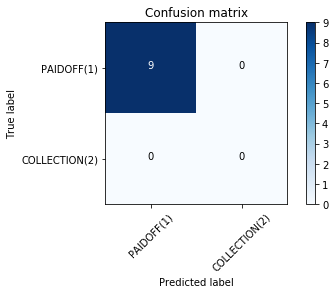

In [113]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF(1)','COLLECTION(2)'],normalize= False,  title='Confusion matrix')

In [114]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.90578817733990147

In [115]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

0.91428571428571426

# Logistic Regression

In [116]:
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt

In [117]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-01-30 11:36:35--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2019-01-30 11:36:35 (12.6 MB/s) - ‘loan_train.csv’ saved [23101/23101]



In [118]:
loan_df = pd.read_csv("loan_train.csv")
loan_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [119]:
import pandas as pd 
gender = {'male': 1,'female': 2} 
loan_df.Gender = [gender[item] for item in loan_df.Gender] 
loanstatus = {'PAIDOFF': 1,'COLLECTION': 2} 
loan_df.loan_status = [loanstatus[item] for item in loan_df.loan_status] 
education1 = {'High School or Below': 1, 'college': 2, 'Bechalor': 3, 'Master or Above': 4}
loan_df.education = [education1[item] for item in loan_df.education]
loan_df.drop(loan_df.columns[[5,6]], axis=1, inplace=True)
print(loan_df) 

     Unnamed: 0  Unnamed: 0.1  loan_status  Principal  terms  age  education  \
0             0             0            1       1000     30   45          1   
1             2             2            1       1000     30   33          3   
2             3             3            1       1000     15   27          2   
3             4             4            1       1000     30   28          2   
4             6             6            1       1000     30   29          2   
5             7             7            1       1000     30   36          2   
6             8             8            1       1000     30   28          2   
7             9             9            1        800     15   26          2   
8            10            10            1        300      7   29          2   
9            11            11            1       1000     15   39          1   
10           12            12            1       1000     30   26          2   
11           13            13           

In [120]:
loan_df.dtypes

Unnamed: 0      int64
Unnamed: 0.1    int64
loan_status     int64
Principal       int64
terms           int64
age             int64
education       int64
Gender          int64
dtype: object

In [121]:
X = np.asarray(loan_df[['Principal', 'terms', 'age', 'education', 'Gender']])
X[0:5]

array([[1000,   30,   45,    1,    1],
       [1000,   30,   33,    3,    2],
       [1000,   15,   27,    2,    1],
       [1000,   30,   28,    2,    2],
       [1000,   30,   29,    2,    1]])

In [122]:
y = np.asarray(loan_df['loan_status'])
y [0:5]

array([1, 1, 1, 1, 1])

In [123]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 0.52,  0.92,  2.33, -1.  , -0.42],
       [ 0.52,  0.92,  0.34,  1.84,  2.38],
       [ 0.52, -0.96, -0.65,  0.42, -0.42],
       [ 0.52,  0.92, -0.49,  0.42,  2.38],
       [ 0.52,  0.92, -0.32,  0.42, -0.42]])

In [124]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 5) (276,)
Test set: (70, 5) (70,)


In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [126]:
yhat = LR.predict(X_test)
yhat

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

In [127]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[ 0.56,  0.44],
       [ 0.62,  0.38],
       [ 0.6 ,  0.4 ],
       [ 0.55,  0.45],
       [ 0.58,  0.42],
       [ 0.59,  0.41],
       [ 0.58,  0.42],
       [ 0.59,  0.41],
       [ 0.55,  0.45],
       [ 0.58,  0.42],
       [ 0.56,  0.44],
       [ 0.57,  0.43],
       [ 0.68,  0.32],
       [ 0.56,  0.44],
       [ 0.63,  0.37],
       [ 0.66,  0.34],
       [ 0.54,  0.46],
       [ 0.6 ,  0.4 ],
       [ 0.56,  0.44],
       [ 0.58,  0.42],
       [ 0.63,  0.37],
       [ 0.57,  0.43],
       [ 0.55,  0.45],
       [ 0.61,  0.39],
       [ 0.67,  0.33],
       [ 0.56,  0.44],
       [ 0.56,  0.44],
       [ 0.7 ,  0.3 ],
       [ 0.56,  0.44],
       [ 0.67,  0.33],
       [ 0.6 ,  0.4 ],
       [ 0.61,  0.39],
       [ 0.61,  0.39],
       [ 0.58,  0.42],
       [ 0.68,  0.32],
       [ 0.61,  0.39],
       [ 0.56,  0.44],
       [ 0.62,  0.38],
       [ 0.62,  0.38],
       [ 0.61,  0.39],
       [ 0.56,  0.44],
       [ 0.58,  0.42],
       [ 0.62,  0.38],
       [ 0.

In [128]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

0.7857142857142857

In [131]:

from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))


[[55  0]
 [ 0  0]]


Confusion matrix, without normalization
[[55  0]
 [ 0  0]]


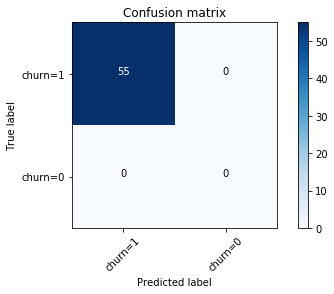

In [132]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)



plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')

In [137]:
print (classification_report(y_test, yhat))

             precision    recall  f1-score   support

          1       0.79      1.00      0.88        55
          2       0.00      0.00      0.00        15

avg / total       0.62      0.79      0.69        70



/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [136]:
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)

0.60097718399940614

# Model Evaluation using Test set

In [133]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [134]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-01-30 11:46:37--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-01-30 11:46:37 (616 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [135]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                |      | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>